In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from superfv import EulerSolver, plot_2d_slice, turbulent_power_specta, plot_timeseries
from superfv.initial_conditions import decaying_isotropic_turbulence

In [2]:
def turbulent_crossing_time(sim):
    idx = sim.variable_index_map
    w = sim.snapshots[0]["w"]
    vx = w[idx("vx")]
    vy = w[idx("vy")]
    v = np.sqrt(vx**2 + vy**2)
    crossing_time = 1 / np.std(v)
    return crossing_time

In [3]:
seed = 1
N = 64
T = [0.08, 0.16, 0.24]

configs = {
    "p0": dict(riemann_solver="hllc", p=0),
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        p=1,
        MUSCL=True,
        MUSCL_limiter="PP2D",
        flux_recipe=2,
    ),
    "ZS3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        lazy_primitives="adaptive",
        ZS=True,
        GL=True,
        include_corners=True,
        PAD={"rho": (0, None)},
    ),
    "MM3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        lazy_primitives="adaptive",
        MOOD=True,
        limiting_vars=("rho", "vx", "vy"),
        cascade="muscl",
        MUSCL_limiter="PP2D",
        max_MOOD_iters=1,
        blend=True,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-8,
        include_corners=True,
        PAD={"rho": (0, None)},
    ),
    "ZS7": dict(
        riemann_solver="hllc",
        p=7,
        flux_recipe=2,
        lazy_primitives="adaptive",
        ZS=True,
        GL=True,
        include_corners=True,
        PAD={"rho": (0, None)},
    ),
    "MM7": dict(
        riemann_solver="hllc",
        p=7,
        flux_recipe=2,
        lazy_primitives="adaptive",
        MOOD=True,
        limiting_vars=("rho", "vx", "vy"),
        cascade="muscl",
        MUSCL_limiter="PP2D",
        max_MOOD_iters=1,
        blend=True,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-8,
        include_corners=True,
        PAD={"rho": (0, None)},
    ),
}

In [4]:
sims = {}
for name, config in configs.items():
    print(f"Running simulation: {name}")
    sim = EulerSolver(
        ic=partial(decaying_isotropic_turbulence, seed=seed, M=10, slope=-5 / 3),
        isothermal=True,
        nx=N,
        ny=N,
        **config,
    )

    try:
        sim.run(
            T,
            q_max=2,
            allow_overshoot=True,
            muscl_hancock=config.get("MUSCL", False),
            log_freq=20,
        )
        sims[name] = sim

        print(f"Turbulent crossing time: {turbulent_crossing_time(sim):.4f}")
    except RuntimeError as e:
        print(f"Simulation '{name}' failed: {e}")

Running simulation: p0
Step #274 @ t=2.40e-01 | dt=1.65e-03 | min(rho)=3.93e-02, min(P)=3.93e-02 | E_cons=0.00e+00 | (ran in 1.39s)
Turbulent crossing time: 0.2290
Running simulation: MUSCL-Hancock
Step #299 @ t=2.40e-01 | dt=1.55e-03 | min(rho)=3.11e-02, min(P)=3.11e-02 | E_cons=0.00e+00 | (ran in 2.85s)
Turbulent crossing time: 0.2290
Running simulation: ZS3
Step #303 @ t=2.41e-01 | dt=1.44e-03 | min(rho)=2.94e-02, min(P)=2.94e-02 | E_cons=0.00e+00 | (ran in 32.68s)
Turbulent crossing time: 0.2290
Running simulation: MM3
Step #316 @ t=2.40e-01 | dt=1.59e-03 | min(rho)=2.86e-02, min(P)=2.86e-02 | E_cons=1.16e-10 | (ran in 39.84s)
Turbulent crossing time: 0.2290
Running simulation: ZS7
Step #301 @ t=2.41e-01 | dt=1.47e-03 | min(rho)=2.97e-02, min(P)=2.97e-02 | E_cons=0.00e+00 | (ran in 57.23s)
Turbulent crossing time: 0.2290
Running simulation: MM7
Step #303 @ t=2.41e-01 | dt=1.63e-03 | min(rho)=2.78e-02, min(P)=2.78e-02 | E_cons=2.91e-11 | (ran in 45.04s)
Turbulent crossing time: 0.22

/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.08 not exactly matched in mesh; using nearest: 0.0803897
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.08 not exactly matched in mesh; using nearest: 0.0803897
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.16 not exactly matched in mesh; using nearest: 0.160772
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.16 not exactly matched in mesh; using nearest: 0.160772
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.24 not exactly matched in mesh; using nearest: 0.240043
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.24 not exactly matched in m

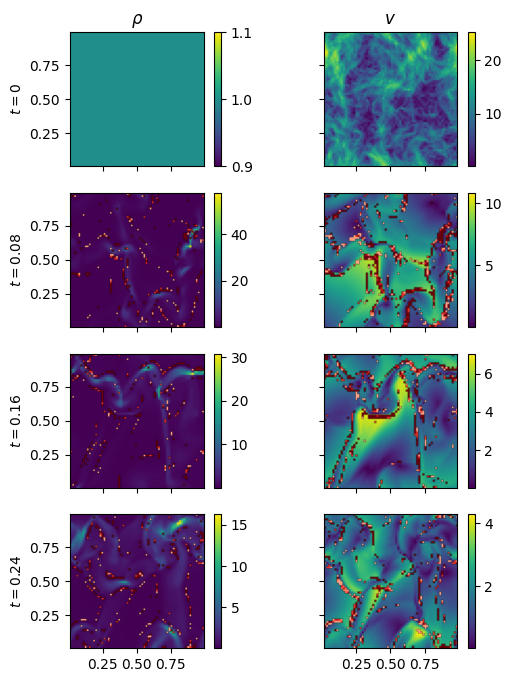

In [5]:
sim = sims["MM3"]

fig, axs = plt.subplots(
    len(T) + 1, 2, sharex=True, sharey=True, figsize=(6, (len(T) + 1) * 2)
)

axs[0, 0].set_title(r"$\rho$")
axs[0, 1].set_title(r"$v$")

for i, t in enumerate([0] + T):
    axs[i, 0].set_ylabel(f"$t={t}$")
    plot_2d_slice(
        sim,
        axs[i, 0],
        "rho",
        cell_averaged=True,
        colorbar=True,
        t=t,
        overlay_troubles=True,
        troubles_alpha=1.0,
    )
    plot_2d_slice(
        sim,
        axs[i, 1],
        "v",
        cell_averaged=True,
        colorbar=True,
        t=t,
        overlay_troubles=True,
        troubles_alpha=1.0,
    )

/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.08 not exactly matched in mesh; using nearest: 0.0801963
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.08 not exactly matched in mesh; using nearest: 0.0801549
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.08 not exactly matched in mesh; using nearest: 0.0803897
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.08 not exactly matched in mesh; using nearest: 0.0803906
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.08 not exactly matched in mesh; using nearest: 0.0807182
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.16 not exactly matched i

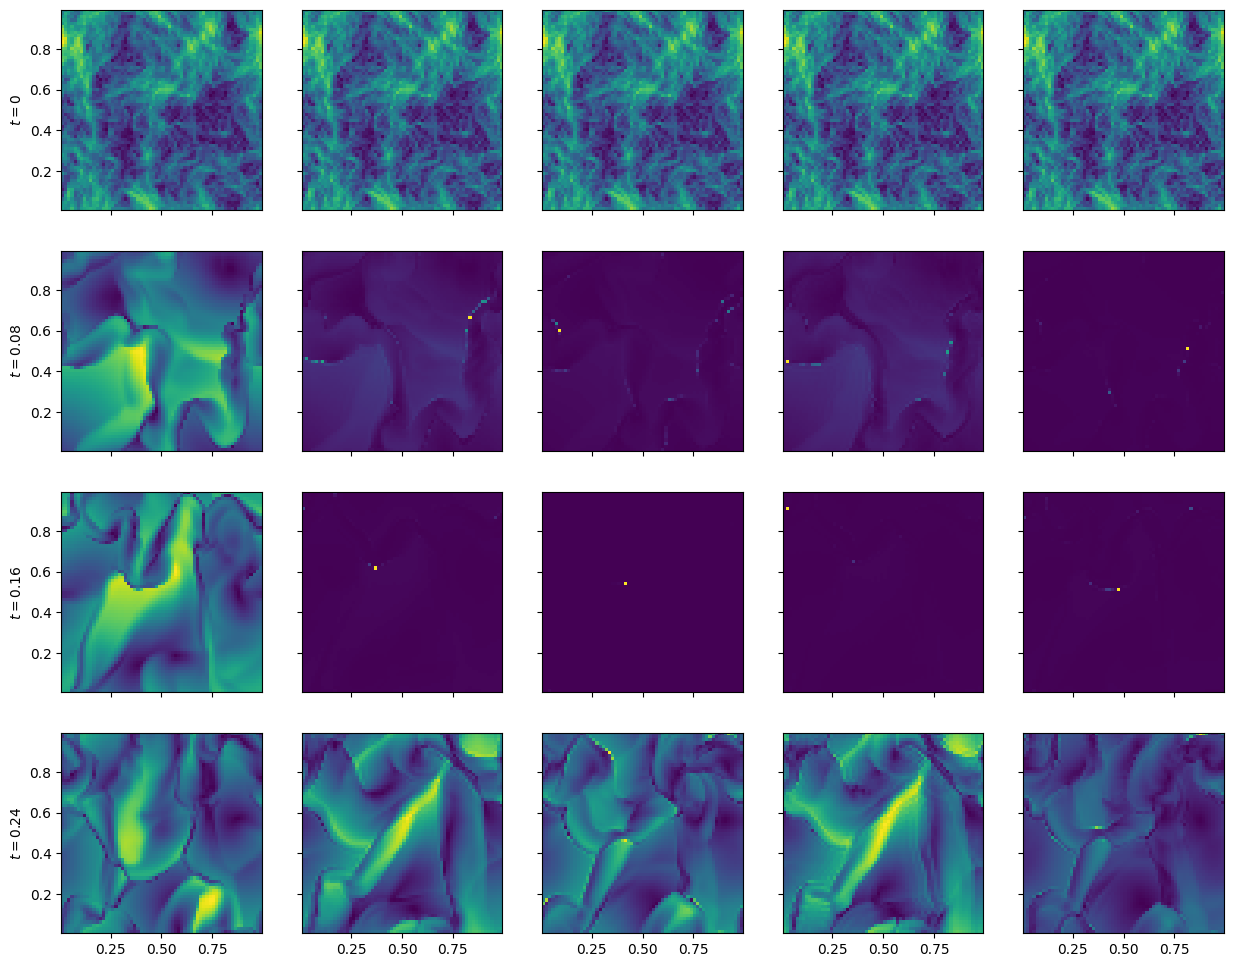

In [6]:
fig, axs = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(15, 12))

for i, t in enumerate([0, *T]):
    axs[i, 0].set_ylabel(f"$t={t}$")

    for j, sim_name in enumerate(["MUSCL-Hancock", "ZS3", "MM3", "ZS7", "MM7"]):
        sim = sims[sim_name]

        # plot_2d_slice(sim, axs[i, j], "rho", t=t, func=lambda x: np.log10(np.maximum(x, 1e-15)), vmin=-3, vmax=3)
        plot_2d_slice(sim, axs[i, j], "v", t=t)

(<matplotlib.image.AxesImage at 0x11795f950>,
 <matplotlib.colorbar.Colorbar at 0x11795c6b0>)

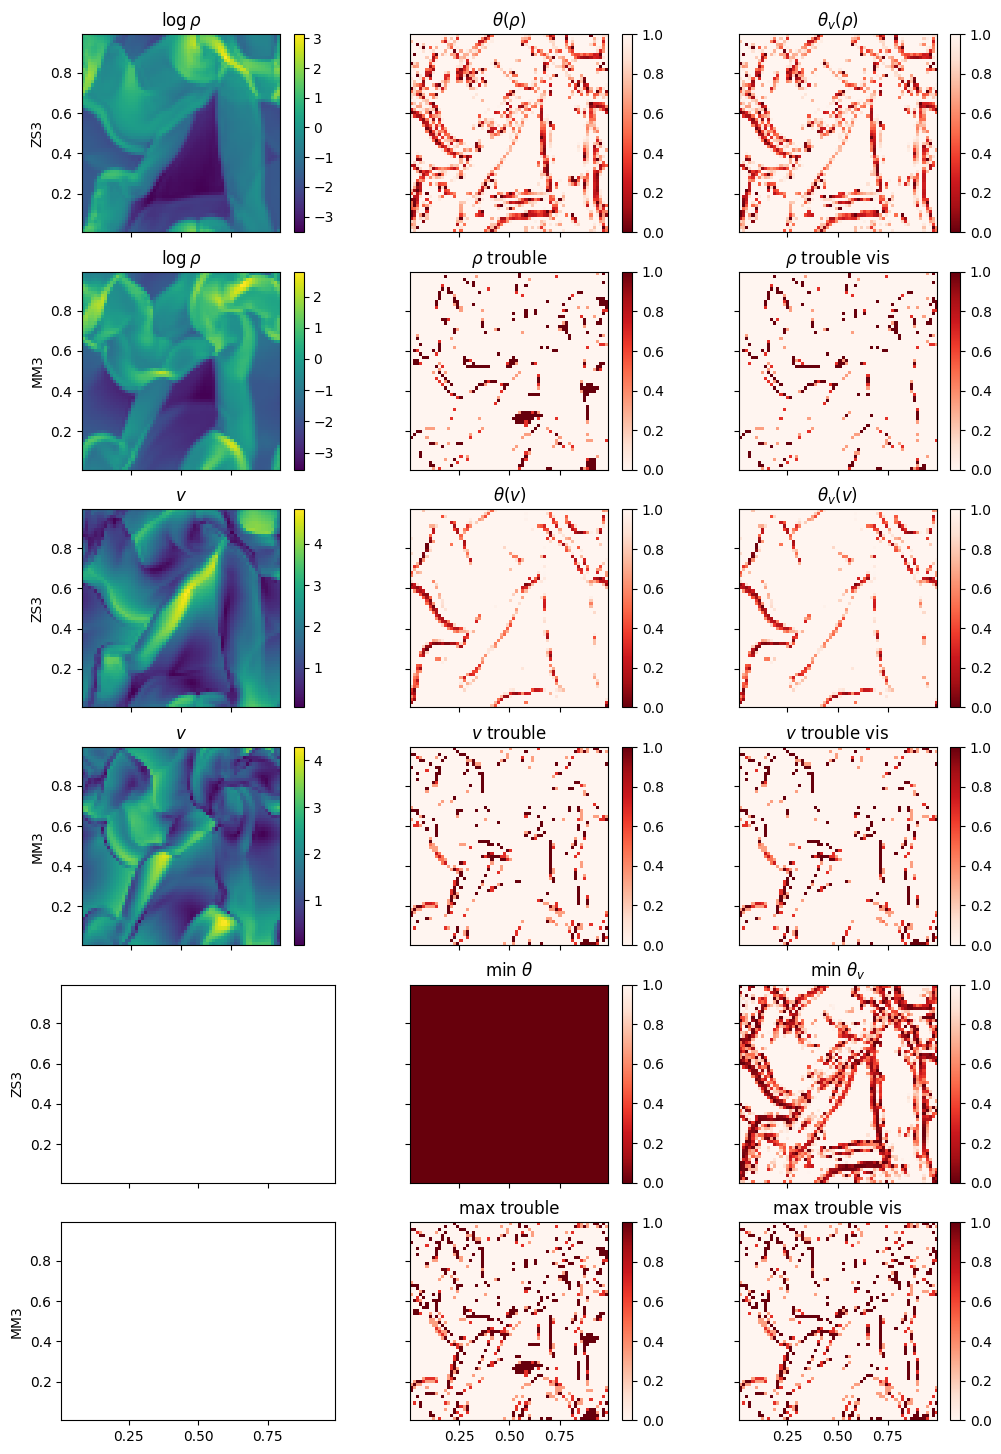

In [7]:
sim1 = sims["ZS3"]
sim2 = sims["MM3"]

fig, axs = plt.subplots(6, 3, sharex=True, sharey=True, figsize=(12, 18))

axs[0, 0].set_ylabel("ZS3")
axs[0, 0].set_title(r"$\log \rho$")
axs[0, 1].set_title(r"$\theta(\rho)$")
axs[0, 2].set_title(r"$\theta_v(\rho)$")

axs[1, 0].set_ylabel("MM3")
axs[1, 0].set_title(r"$\log \rho$")
axs[1, 1].set_title(r"$\rho$ trouble")
axs[1, 2].set_title(r"$\rho$ trouble vis")

axs[2, 0].set_ylabel("ZS3")
axs[2, 0].set_title(r"$v$")
axs[2, 1].set_title(r"$\theta(v)$")
axs[2, 2].set_title(r"$\theta_v(v)$")

axs[3, 0].set_ylabel("MM3")
axs[3, 0].set_title(r"$v$")
axs[3, 1].set_title(r"$v$ trouble")
axs[3, 2].set_title(r"$v$ trouble vis")

axs[4, 0].set_ylabel("ZS3")
axs[4, 1].set_title(r"min $\theta$")
axs[4, 2].set_title(r"min $\theta_v$")

axs[5, 0].set_ylabel("MM3")
axs[5, 1].set_title(r"max trouble")
axs[5, 2].set_title(r"max trouble vis")

style = dict(cell_averaged=True, colorbar=True)
theta_style = dict(theta=True, cmap="Reds_r", vmin=0, vmax=1, colorbar=True)
trouble_style = dict(troubles=True, cmap="Reds", vmin=0, vmax=1, colorbar=True)

plot_2d_slice(sim1, axs[0, 0], "rho", func=lambda x: np.log(x), **style)
plot_2d_slice(sim1, axs[0, 1], "rho", visualization=False, **theta_style)
plot_2d_slice(sim1, axs[0, 2], "rho", visualization=True, **theta_style)

plot_2d_slice(sim2, axs[1, 0], "rho", func=lambda x: np.log(x), **style)
plot_2d_slice(sim2, axs[1, 1], "rho", visualization=False, **trouble_style)
plot_2d_slice(sim2, axs[1, 2], "rho", visualization=True, **trouble_style)

plot_2d_slice(sim1, axs[2, 0], "v", **style)
plot_2d_slice(sim1, axs[2, 1], "v", visualization=False, **theta_style)
plot_2d_slice(sim1, axs[2, 2], "v", visualization=True, **theta_style)

plot_2d_slice(sim2, axs[3, 0], "v", **style)
plot_2d_slice(sim2, axs[3, 1], "v", visualization=False, **trouble_style)
plot_2d_slice(sim2, axs[3, 2], "v", visualization=True, **trouble_style)

plot_2d_slice(sim1, axs[4, 1], "min", visualization=False, **theta_style)
plot_2d_slice(sim1, axs[4, 2], "min", visualization=True, **theta_style)

plot_2d_slice(sim2, axs[5, 1], "max", visualization=False, **trouble_style)
plot_2d_slice(sim2, axs[5, 2], "max", visualization=True, **trouble_style)

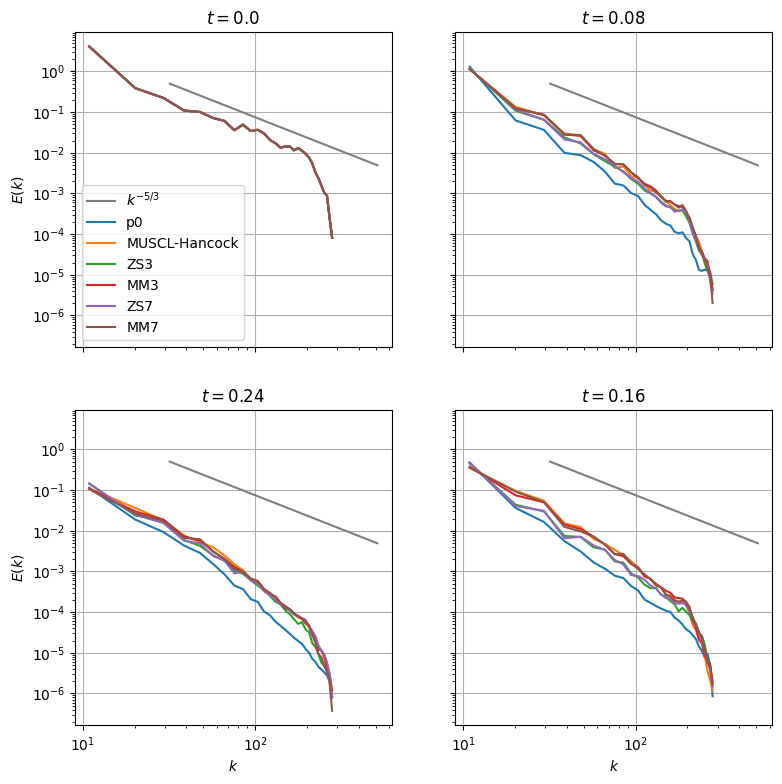

In [8]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 9))
axs[1, 0].set_xlabel(r"$k$")
axs[1, 1].set_xlabel(r"$k$")
axs[0, 0].set_ylabel(r"$E(k)$")
axs[1, 0].set_ylabel(r"$E(k)$")
axs[0, 0].set_xscale("log")
axs[0, 0].set_yscale("log")

for (k, t), (i, j) in zip(enumerate([0.0, *T]), [(0, 0), (0, 1), (1, 1), (1, 0)]):
    axs[i, j].set_title(f"$t={t}$")
    axs[i, j].grid()
    axs[i, j].plot(
        [32, 512],
        [5e-1, 5e-1 * (512 / 32) ** (-5 / 3)],
        label=r"$k^{-5/3}$",
        color="gray",
    )

    for name, sim in sims.items():
        w = sim.snapshots[k]["w"]
        k_centers, E_k = turbulent_power_specta(
            sim.xp, sim.variable_index_map, w, sim.mesh, nbins=30, binmode="linear"
        )

        axs[i, j].plot(
            k_centers, E_k, marker="none", mfc="none", linestyle="-", label=name
        )

axs[0, 0].legend()

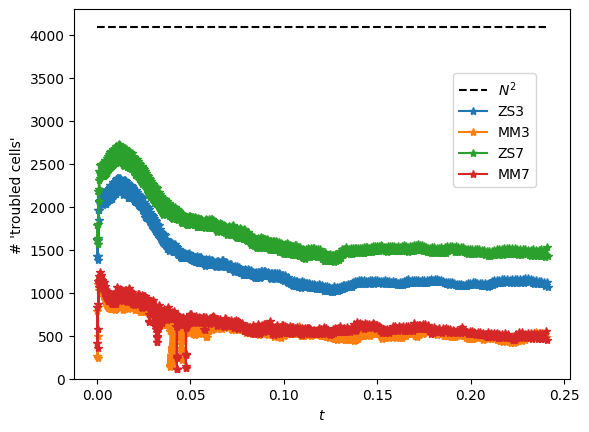

In [9]:
fig, ax = plt.subplots()
ax.set_ylim(0, 1.05 * N**2)

ax.set_xlabel(r"$t$")
ax.set_ylabel("# 'troubled cells'")

ax.plot([0, T[-1]], [N**2, N**2], "k--", label=r"$N^2$")
plot_timeseries(
    sims["ZS3"],
    ax,
    "max",
    one_minus_theta=True,
    visualization=True,
    label="ZS3",
    marker="*",
)
plot_timeseries(
    sims["MM3"], ax, "max", troubles=True, visualization=True, label="MM3", marker="*"
)
plot_timeseries(
    sims["ZS7"],
    ax,
    "max",
    one_minus_theta=True,
    visualization=True,
    label="ZS7",
    marker="*",
)
plot_timeseries(
    sims["MM7"], ax, "max", troubles=True, visualization=True, label="MM7", marker="*"
)

ax.legend(bbox_to_anchor=(0.75, 0.5))

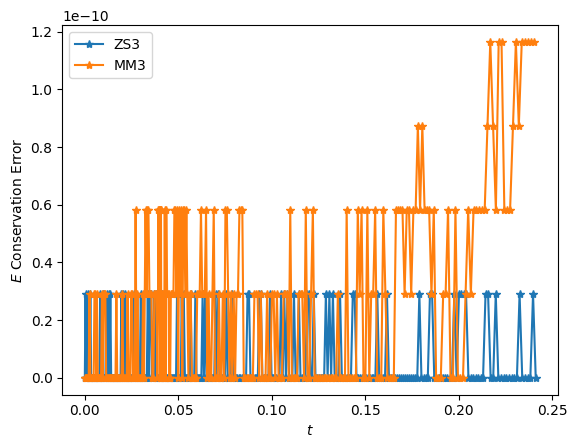

In [10]:
fig, ax = plt.subplots()

ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$E$ Conservation Error")

style = dict(marker="*")
plot_timeseries(sims["ZS3"], ax, "E_cons", label="ZS3", **style)
plot_timeseries(sims["MM3"], ax, "E_cons", label="MM3", **style)
# plot_timeseries(sims["ZS7"], ax, "E_cons", label="ZS7", **style)
# plot_timeseries(sims["MM7"], ax, "E_cons", label="MM7", **style)

ax.legend()

In [11]:
v_xy = sims["p0"].snapshots[0]["w"][sims["p0"].variable_index_map("v")]
v = np.sqrt(np.sum(v_xy**2, axis=0))

1 / np.std(v)

np.float64(0.22899628247547316)